In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import ipdb
from collections import defaultdict

##############################################################################################

'''
Here is the class definition for the objective function 1, in which we utilize nonprobabilistic SGD
with temporal dynamics and KNN post processing
'''
class ObjectiveFunction1(object):
	def __init__(self, training, testing, movie_bias_time_name, features = 10, lmbda = .1):
		self.train_data = training
		self.test_data = testing
		self.num_users = 610
		self.num_movies = 9724
		self.features = features
		self.mu = np.average(self.train_data[:,2]) #### CALCULATE TOTAL AVERAGE RATING HERE!!
		self.lmbda = lmbda
		self.p = None
		self.q = None
		self.learning_rate = 0.1
		self.movie_bias = pd.read_csv("bi_global.csv")[['val']].to_numpy()
		self.user_bias = pd.read_csv("bu_global.csv")[['val']].to_numpy()
		self.movie_bias_time = np.zeros((self.num_movies))# np.random.uniform(low=-0.1, high=0.1, size = self.num_movies)
		self.user_bi_reg = self.lmbda
		self.movie_bi_reg = self.lmbda
		self.store_movie_idx(movie_bias_time_name)

#This method initalizes the q and p matrices randomly, as well as creates an initial r matrix

	def matrix_factorization(self):
		np.random.seed(0)
		self.p = np.random.normal(scale=1./self.features,size=(self.num_users, self.features))#np.random.uniform(low=-0.5, high=0.5, size=(self.num_users, self.features))
		self.q = np.random.normal(scale=1./self.features,size=(self.num_movies, self.features))#np.random.uniform(low=-0.5, high=0.5, size=(self.num_movies, self.features))
		self.r = np.matmul(self.p, self.q.T)  #SHAPE: 610 X 9472

#This method calculates the temporal dynamics regularization terms
	def temp_dyn_pred_reg(self, user_id, movie_id, train = True):
		temp_dyn = self.mu + self.movie_bias[movie_id] + self.user_bias[user_id] + self.movie_bias_time[movie_id]
		return temp_dyn

#This method maps the movie id's to a continuous movie index for easy manipulation
	def store_movie_idx(self, movie_bias_time_name):
		#df =  pd.read_csv("../data/ml-latest-small/movies.csv")
		df = pd.read_csv("../data/ml-latest-small/ratings.csv")
		idx = [i for i in range(9724)]
		self.movie_id2idx = dict(zip(df.movieId.unique(), idx))
		df2 = pd.read_csv(movie_bias_time_name)
		new = []
		for i in range(len(df2['movieId'])):
			update = self.movie_id2idx[df2['movieId'][i]]
			new.append(update)
		df2['movie_index'] = new
		bibin = df2[['movie_index','bi']].to_numpy()

		for i in range(len(bibin)):
			self.movie_bias_time[int(bibin[i,0])] = bibin[i,1]

# This method trains the objective function via SGD with temporal reg 
	def train_obj_function(self, batch_size = 1, obj_function = 'GD'):

		num_batches = len(self.train_data)//batch_size 
		train_loss_values = np.zeros((num_batches))
		validation_loss_values = np.zeros((num_batches))

		train_loss = 0

		for i in range(num_batches):
			
			#Inialize gradients
			dl_dp, dl_dq = 0,0
			#find gradients
			for j in range(batch_size):

				user_id = self.train_data[i*batch_size+j,:][0] - 1
				movie_id = self.movie_id2idx[self.train_data[i*batch_size+j,:][1]]
				actual_rating = self.train_data[i*batch_size+j,:][2]				

				prediction = np.matmul(self.q[movie_id,:], self.p[user_id,:].T) + self.temp_dyn_pred_reg(user_id, movie_id)
				dpred_dq = self.p[user_id,:] 
				dpred_dp = self.q[movie_id,:]

				if obj_function == 'GD':

					train_loss_values[i] = (actual_rating - prediction)**2 + self.GDreg(user_id, movie_id) + self.lmbda*(self.user_bias[user_id]**2 + self.movie_bias[movie_id]**2 + self.movie_bias_time[movie_id]**2)
					dl_dq += 2*(actual_rating - prediction)*dpred_dq - self.deriv_GDreg(self.q, movie_id)
					dl_dp += 2*(actual_rating - prediction)*dpred_dp - self.deriv_GDreg(self.p, user_id)

				#update p and q matrices via gradient descent, add value to train_loss array for predictionlotting later
				self.p[user_id,:] += self.learning_rate*dl_dp
				self.q[movie_id,:] += self.learning_rate*dl_dq

				#update biase values  via SGD
				dl_dbu = 2*(actual_rating - prediction) - 2*self.user_bi_reg *self.user_bias[user_id]
				dl_dbi = 2*(actual_rating - prediction) - 2*self.movie_bi_reg *self.movie_bias[movie_id]
				dl_dbut = 2*(actual_rating - prediction) - 2*self.lmbda *self.movie_bias_time[movie_id]
				self.movie_bias_time[movie_id] += self.learning_rate*dl_dbut
				self.user_bias[user_id] += self.learning_rate*dl_dbu
				self.movie_bias[movie_id] += self.learning_rate*dl_dbi
		return train_loss_values

	def GDreg(self, user_id, movie_id):
		return self.lmbda*(np.linalg.norm(self.p[user_id,:])**2 + np.linalg.norm(self.q[movie_id,:])**2)
	def deriv_GDreg(self,matrix, num):
		return 2*self.lmbda*np.linalg.norm(matrix[num,:])*matrix[num,:]

	#testing loss for plotting
	def get_validation_loss(self, obj_function ='GD'):
		test_loss = 0
		test_loss_values = np.zeros((len(self.test_data)))
		for j in range(len(self.test_data)):
			user_id = self.test_data[j,:][0]-1
			movie_id = self.movie_id2idx[self.test_data[j,:][1]]
			actual_rating = self.test_data[j,:][2]
			prediction = np.matmul(self.q[movie_id,:], self.p[user_id,:].T) +  self.temp_dyn_pred_reg(user_id, movie_id)
			if obj_function == 'GD':
				test_loss_values[j] = (actual_rating - prediction)**2 + self.GDreg(user_id, movie_id)
			
		return np.average(test_loss_values)

	#Main training method in which you can train for a specified number of epochs and then plot loss + error
	def train_gd(self, objfunc, num_epochs= 10):
			
		val_loss = np.zeros((num_epochs))
		train_loss = np.zeros((num_epochs))

		val_error = np.zeros((num_epochs))
		train_error = np.zeros((num_epochs))

		train_KNN = np.zeros((num_epochs))
		test_KNN = np.zeros((num_epochs))

		for i in range(num_epochs):
			np.random.shuffle(self.train_data)
			train_error[i] = self.predict()
			val_error[i] = self.predict(train=False)
			train_loss_array = self.train_obj_function(obj_function = objfunc)
			train_loss[i] = np.average(train_loss_array)
			val_loss[i] = self.get_validation_loss(obj_function = objfunc)
			knnpred = self.get_pred_mat()
			train_KNN[i] = self.KNN_predict()
			test_KNN[i] = self.KNN_predict(train=False)

		#plot results
		x = np.arange(1, num_epochs+1) 

		fig, (loss, error, KNN) = plt.subplots(1, 3)
		fig.suptitle("Nonprobabilistic Gradient Descent training")
		loss.set_xlabel("# of Epochs") 
		loss.set_ylabel("loss") 
		loss.plot(x,train_loss,label='train loss') 
		loss.plot(x,val_loss, label='test loss') 
		loss.legend()
		error.set_xlabel("# of Epochs") 
		error.set_ylabel("SGD error") 
		error.plot(x,train_error,label='train error') 
		error.plot(x,val_error, label='test error') 
		error.legend()

		KNN.set_xlabel("# of Epochs") 
		KNN.set_ylabel("KNN + SGD error") 
		KNN.plot(x,train_KNN,label='train error') 
		KNN.plot(x,test_KNN, label='test error') 
		KNN.legend()
		plt.show()

	#this method evaluates your model and outputs your percentage of incorrect predictions for SGD
	def predict(self, train = True):
		self.r = np.matmul(self.p, self.q.T)
		if train:
			data = self.train_data
		else:
			data = self.test_data
		total = len(data)
		correct = 0
		for i in range(total):
			user_id = data[i,0] - 1
			movie_id = self.movie_id2idx[data[i,1]]
			pred = round((self.r[user_id, movie_id] + self.mu +  self.movie_bias_time[movie_id] + self.user_bias[user_id][0] + self.movie_bias[movie_id][0])*2)/2
			if pred == data[i,2]:
				correct +=1
		return (total-correct)/total

	#this method evaluates your model and outputs your percentage of incorrect predictions for KNN post processing
	def KNN_predict(self, train = True):
		if train:
			data = self.train_data
		else:
			data = self.test_data
		total = len(data)
		correct = 0
		for i in range(total):
			user_id = data[i,0] - 1
			movie_id = self.movie_id2idx[data[i,1]]
			pred = self.pred_mat[user_id, movie_id]
			if pred == data[i,2]:
				correct +=1
		return (total-correct)/total

	def update_q_matrix(self, q_matrix):
		self.q = q_matrix
	def get_q_matrix(self):
		return self.q
	def get_p_matrix(self):
		return self.p

	#this method creates the cosine similarity matrix with your learned q matrix
	def cosine_sim_mat(self):
		from sklearn.metrics.pairwise import cosine_similarity
		self.sim_mat = cosine_similarity(self.q)
		self.watch_dict = self.make_watch_dict(self.train_data)
		np.fill_diagonal(self.sim_mat, 0)

	# this method creates the prediction matrix 
	def make_prediction_matrix(self):
		self.pred_mat = np.zeros((self.num_users, self.num_movies))
		for i in range(len(self.pred_mat)):
			for j in range(len(self.pred_mat[0])):
				self.pred_mat[i,j] = self.argmaxcos(i,j)
		return self.pred_mat

	def get_pred_mat(self):
		self.cosine_sim_mat()
		self.make_watch_dict(self.train_data)
		self.make_prediction_matrix()
		return self.pred_mat

	#this method supports the prediction matrix creation by getting the argmax of cosine similarity values 
	def argmaxcos(self, i,j):
		user_idx = i + 1
		pred_movie_idx = j
		all_user_movies_watched = self.watch_dict[i + 1]
		if len(all_user_movies_watched)== 0:
			return 3.5

		temp = np.zeros((len(all_user_movies_watched)))
		for k in range(len(all_user_movies_watched)):
			movie = all_user_movies_watched[k][0]
			movie = self.movie_id2idx[movie] # ---> TRANSOFRM
			temp[k] = self.sim_mat[pred_movie_idx,movie]
		new_loc = np.argmax(temp)
		rating = all_user_movies_watched[new_loc][1]
		return rating

	#this method makes a dictionary of all the users in the training set and the movies + respective ratings of all movies that they watched
	def make_watch_dict(self, data):
		watch_dictionary = defaultdict(list)
		for i in range(len(data)):
			user_id = data[i,0]
			movieId = data[i,1]
			rating = data[i,2]
			watch_dictionary[user_id].append((movieId, rating))
		self.watch_dict = watch_dictionary


In [6]:
data_path = 'train_test_data.xlsx'
xl_file = pd.ExcelFile(data_path)
df_names= [('bin1_train','bin1_test'),('bin2_train','bin2_test'),('bin3_train','bin3_test')]
dfs = {sheet_name: xl_file.parse(sheet_name) 
    for sheet_name in xl_file.sheet_names}

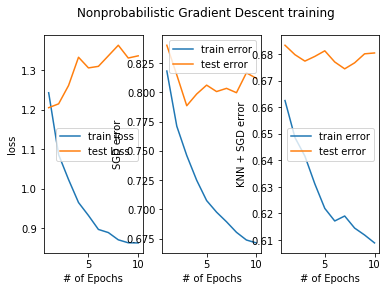

In [7]:
#Bin 1
bias_time = "bi_data1.csv"
train_data1 = dfs[df_names[0][0]][['userId','movieId','rating']].to_numpy().astype(int)
test_data1 = dfs[df_names[0][1]][['userId','movieId','rating']].to_numpy().astype(int)
objfunc1 = ObjectiveFunction1(train_data1, test_data1, bias_time)
objfunc1.matrix_factorization()
objfunc1.train_gd('GD')
q = objfunc1.get_q_matrix()
p1 = objfunc1.get_p_matrix()

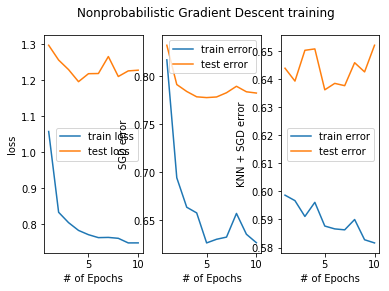

In [9]:
#Bin 2
bias_time2 = "bi_data2.csv"
train_data2 = dfs[df_names[1][0]][['userId','movieId','rating']].to_numpy().astype(int)
test_data2 = dfs[df_names[1][1]][['userId','movieId','rating']].to_numpy().astype(int)
objfunc2 = ObjectiveFunction1(train_data2, test_data2, bias_time2 )
objfunc2.matrix_factorization()
objfunc2.update_q_matrix(q)
objfunc2.train_gd('GD')
q = objfunc2.get_q_matrix()
p2 = objfunc2.get_p_matrix()

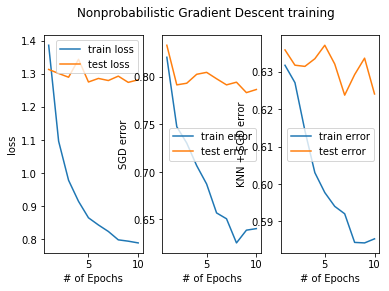

In [10]:
#Bin 3
bias_time3 = "bi_data3.csv"
train_data3 = dfs[df_names[2][0]][['userId','movieId','rating']].to_numpy().astype(int)
test_data3 = dfs[df_names[2][1]][['userId','movieId','rating']].to_numpy().astype(int)
objfunc3 = ObjectiveFunction1(train_data3, test_data3, bias_time3)
objfunc3.matrix_factorization()
objfunc3.update_q_matrix(q)
objfunc3.train_gd('GD')
q = objfunc3.get_q_matrix()
p3 = objfunc3.get_p_matrix()